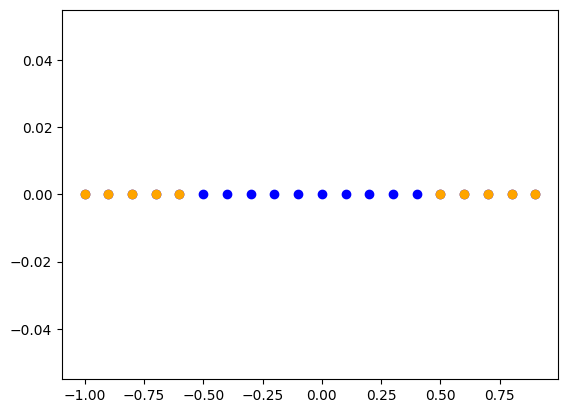

In [1]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt

# Generamos nuestro dataset

data = np.arange(-1,1,0.1)
labels = np.ones(len(data))
labels[len(data)//4:-len(data)//4] *= -1

plt.scatter(data, np.zeros(len(data)), color = "blue")
plt.scatter(data[:len(data)//4], np.zeros(len(data)//4), color = "orange")
plt.scatter(data[-len(data)//4:], np.zeros(len(data)//4), color = "orange")

In [2]:

# Entrenamiento estandar de una red neuronal cuántica

def feature_map(x):
    qml.Hadamard(wires = 0)
    qml.RZ(x , wires = 0)

def variational_block(params):
    qml.U3(params[0], params[1], params[2], wires = 0)
    
dev = qml.device("default.qubit", wires = 1)

@qml.qnode(dev)
def circuit(x, params):
    
    feature_map(x)
    variational_block(params)
    
    return qml.expval(qml.PauliZ(0))


def error(data, labels, params):
    
    err = 0
    for i in range(len(data)):
        err -= labels[i] * circuit(data[i], params)
    
    return err / len(data)

def accuracy(data, labels, params):  
    
    n = 0
    for i in range(len(data)):
        if labels[i] == np.sign(circuit(data[i], params)):
            n += 1
    
    return n / len(data)
    

def train(data, labels, error_function, params, stepsize = 0.1, epochs = 100, plot = True):

    opt = qml.AdagradOptimizer(stepsize = stepsize)

    costs = []
    for epoch in range(epochs):
        params, cost = opt.step_and_cost(lambda params: error_function(data, labels, params), params)
        costs.append(cost)
      
    if plot:
        plt.plot(costs)
        
    return params
    

/opt/conda/envs/pennylane/lib/python3.9/site-packages/autograd/numpy/numpy_vjps.py:698: ComplexWarning: Casting complex values to real discards the imaginary part
  onp.add.at(A, idx, x)


0.5

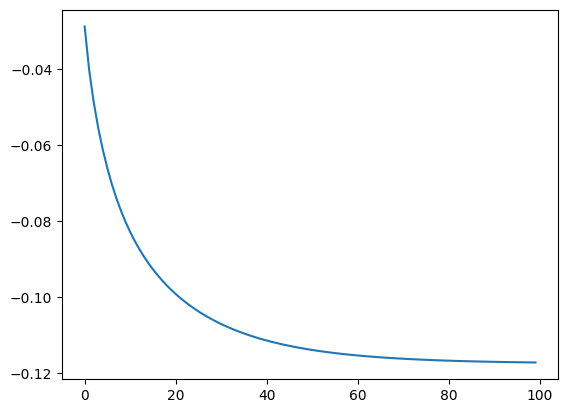

In [3]:
initial_params = np.random.rand(3, requires_grad = True)
params = train(data, labels, error, initial_params)
accuracy(data, labels, params)

Recordemos que la formula del error para entrenar nuestro feature map F es:


$$\text{Error} = -\sum_i\sum_j y_iy_j\langle F(x_i)^{\dagger}F(x_j)\rangle$$

Definiremos por tanto un feature map variacional y minimizaremos dicho error.

In [4]:
def feature_map(x, feature_param):
    qml.Hadamard(wires = 0)
    qml.RZ(x * feature_param, wires = 0)
    
def feature_error(data, labels, feature_param):
    
    dev = qml.device("default.qubit", wires = 1)
    
    @qml.qnode(dev)
    def circuit(x1, x2):
        feature_map(x1, feature_param)
        qml.adjoint(feature_map)(x2, feature_param)
        return qml.probs(wires = 0)
    
    err = 0
    for i in range(len(data)):
        for j in range(i, len(data)):
            err -= labels[i] * labels[j] * circuit(data[i], data[j])[0]
            
    return err
            

tensor([3.16872571], requires_grad=True)

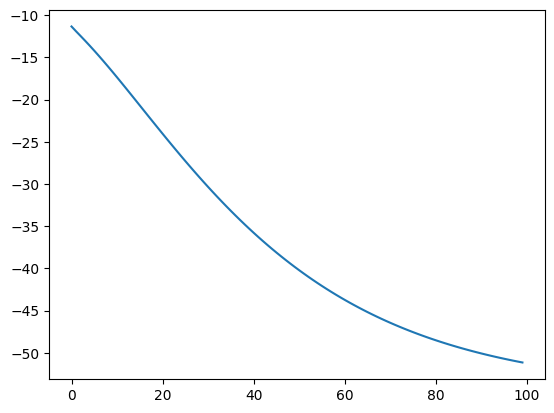

In [5]:
initial_param = np.random.rand(1, requires_grad = True)
param = train(data, labels, feature_error, initial_param)
param

Llegamos a este punto ya tienes el parámetro optimo! 

Prueba a añadirlo en el feature map del modelo inicial para ver como mejoran los resultados 😄